## IMPROVEMENT ON THE EXISTING ML SOLUTIONS:-

1) We would featurize the two question pairs with the help of simple TFIDF vectorizer and would train Logistic Regression and Linear SVM to separate out the duplicate and non-duplicate pairs.

2) We would perform hyperparameter tuning of XgBoost models using RandomsearchCV with TF-IDF W2V mean vector to reduce the log loss.

## IMPORTING THE LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import log_loss, accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
import xgboost as xgb
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibratedClassifierCV

## IMPORTING THE TRAINING DATA

In [2]:
df_train = pd.read_csv("train.csv")

df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
df_train['question1'] = df_train['question1'].apply(lambda x: str(x))
df_train['question2'] = df_train['question2'].apply(lambda x: str(x))

## PREPROCESSING THE QUESTIONS :- REMOVING (,),#,?....

In [4]:
STOP_WORDS = stopwords.words("english")

def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will").replace('\\r',' ').replace('\\t',' ')\
                           .replace('\\"',' ').replace('\\n',' ')
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    x = re.sub('[0-9]+',' ', x)
    x = re.sub('[^A-Za-z]+',' ', x)
    x = re.sub('[!"#$%&\'()*+,-./:;<=>@[\\]^_`{|}~]+',' ', x)
    x = ' '.join(e for e in x.split() if e.lower() not in STOP_WORDS)
    
    #porter = PorterStemmer()
    #pattern = re.compile('\W')
    
    #if type(x) == type(''):
    #    x = re.sub(pattern, ' ', x)
    
    
    #if type(x) == type(''):
    #    x = porter.stem(x)
    #    example1 = BeautifulSoup(x)
    #    x = example1.get_text()
        
    return x    

In [5]:
df_train["question1"] = df_train["question1"].fillna("").apply(preprocess)
df_train["question2"] = df_train["question2"].fillna("").apply(preprocess)

## TRAIN-TEST SPLIT (70:30)

In [6]:
X = df_train.drop("is_duplicate",axis=1)
Y = df_train.iloc[:,-1]
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30, stratify = Y, random_state = 42)
X_tr,X_CV,Y_tr,Y_CV = train_test_split(X_train,Y_train, test_size = 0.30, stratify = Y_train, random_state = 42)

In [7]:
X_tr.head()

,id,qid1,qid2,question1,question2
227100,227100,335860,335861,contribution mahatma gandhi make india free,blue light blocking glasses help eye strain
74788,74788,128104,128105,best driving school kolkata,best driving school chandigarh
318288,318288,207125,370865,interesting products innovations post properti...,interesting products innovations boston proper...
321353,321353,447046,447047,shoot nuke mid air missile defense system,romania anti missile defense system threat rus...
203440,203440,203506,266578,increase fps frames per second dota,human eye fps frames per second something rota...


In [8]:
X_test.head()

,id,qid1,qid2,question1,question2
380200,380200,398338,511809,appropriate meryl streep use golden globes spe...,meryl streep using position attack president
345456,345456,120456,473749,forgot screen unlock pin code htc unlock,unlock htc
219262,219262,326090,326091,book want read,choose books read
231835,231835,341728,341729,know true,know true
316926,316926,314306,442046,seen bald men treated equally others west indi...,indian guys think beautiful bald girls


In [9]:
print(X_tr.shape, X_CV.shape,  X_test.shape)

(198102, 5) (84901, 5) (121287, 5)


## VECTORIZING THE QUESTIONS INTO TFIDF

In [10]:
train_question1 = list(X_tr['question1'])
train_question2 = list(X_tr['question2'])
val_question1 = list(X_CV['question1'])
val_question2 = list(X_CV['question2'])
test_question1 = list(X_test['question1'])
test_question2 = list(X_test['question2'])

tfidf_vec = TfidfVectorizer(min_df = 10, max_features = 15000)
tr_matq1 = tfidf_vec.fit_transform(train_question1)
te_matq1 = tfidf_vec.transform(test_question1)
val_matq1 = tfidf_vec.transform(val_question1)
tr_matq2 = tfidf_vec.fit_transform(train_question2)
te_matq2 = tfidf_vec.transform(test_question2)
val_matq2 = tfidf_vec.transform(val_question2)

In [11]:
print(tr_matq1.shape, val_matq1.shape, te_matq1.shape)

(198102, 9619) (84901, 9619) (121287, 9619)


In [12]:
print(tr_matq2.shape, val_matq2.shape, te_matq2.shape)

(198102, 9383) (84901, 9383) (121287, 9383)


## IMPORTING THE BASIC AND ADVANCED FEATURES

#### BASIC FEATURES

In [13]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    basic_features = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [14]:
basic_features.shape

(404290, 17)

#### ADVANCED FEATURES

In [15]:
if os.path.isfile('nlp_features_train.csv'):
    advanced_features = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

In [16]:
advanced_features.shape

(404290, 21)

## SCALING THE BASIC AND ADVANCED FEATURES USING MINMAXSCALER

In [17]:
basic_features.drop(['id','qid1','qid2','question1','question2','is_duplicate'], axis=1, inplace=True)
advanced_features.drop(['id','qid1','qid2','question1','question2','is_duplicate'], axis=1, inplace=True)

In [18]:
from sklearn.preprocessing import MinMaxScaler

minmax_sc = MinMaxScaler()

basic_features_scaled = minmax_sc.fit_transform(basic_features)
advanced_features_scaled = minmax_sc.fit_transform(advanced_features)

## GETTING THE TRAIN AND TEST SETS OF THE BASIC AND ADVANCED FEATURES

In [19]:
tr_indices = list(X_tr.index.values)
val_indices = list(X_CV.index.values)
te_indices = list(X_test.index.values)

In [20]:
basic_feat_train = basic_features.iloc[tr_indices,:]
advanced_feat_train = advanced_features.iloc[tr_indices,:]
basic_feat_val = basic_features.iloc[val_indices,:]
advanced_feat_val = advanced_features.iloc[val_indices,:]
basic_feat_test = basic_features.iloc[te_indices,:]
advanced_feat_test = advanced_features.iloc[te_indices,:]

In [21]:
basic_feat_train.head()

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
227100,1,1,63,54,11,9,0.0,20.0,0.000000,2,0
74788,2,1,44,47,8,8,7.0,16.0,0.437500,3,1
318288,2,2,103,105,17,17,16.0,34.0,0.470588,4,0
321353,1,1,62,120,13,22,2.0,32.0,0.062500,2,0
203440,2,1,53,163,11,30,4.0,36.0,0.111111,3,1


In [22]:
advanced_feat_train.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
227100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,10.0,38,38,33,37,0.036364
74788,0.749981,0.749981,0.999975,0.999975,0.874989,0.874989,0.0,1.0,0.0,8.0,90,79,85,86,0.800000
318288,0.857131,0.857131,0.999990,0.999990,0.941171,0.941171,1.0,1.0,0.0,17.0,98,94,98,97,0.576923
321353,0.428565,0.333330,0.199996,0.090908,0.307690,0.159999,0.0,0.0,12.0,19.0,58,49,38,52,0.380952
203440,0.571420,0.285712,0.000000,0.000000,0.363633,0.133333,0.0,0.0,19.0,20.5,59,37,36,68,0.500000


## FINAL FEATURE MATRIX FOR THE TFIDF VECTORS

In [23]:
from scipy.sparse import hstack

tfidf_train = hstack((basic_feat_train, advanced_feat_train, tr_matq1, tr_matq2))
tfidf_val = hstack((basic_feat_val, advanced_feat_val, val_matq1, val_matq2))
tfidf_test = hstack((basic_feat_test, advanced_feat_test, te_matq1, te_matq2))

In [24]:
tfidf_train.shape

(198102, 19028)

## FUNCTION FOR PLOTTING CONFUSION MATRIX

In [25]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

## LOGISTIC REGRESSION

#### SKLEARN'S LINEAR_MODEL LOGISTIC REGRESSION

For values of alpha =  1e-05 The validation log loss is: 0.47245963659268053
For values of alpha =  0.0001 The validation log loss is: 0.4557228552139547
For values of alpha =  0.001 The validation log loss is: 0.4536745286081456
For values of alpha =  0.01 The validation log loss is: 0.45312481125405485
For values of alpha =  0.1 The validation log loss is: 0.4545918949329237
For values of alpha =  1 The validation log loss is: 0.4545590119580847
For values of alpha =  10 The validation log loss is: 0.45301761347890657


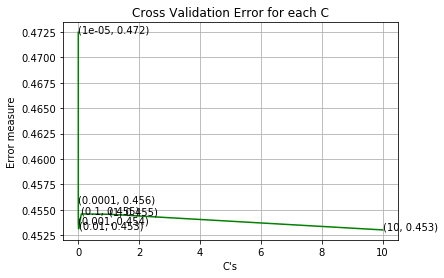

The best C for the Logistic Regression model is : 10
For values of best C =  10 The train log loss is: 0.4558369411706949
For values of best C =  10 The test log loss is: 0.4548926827693305
Total number of data points : 121287


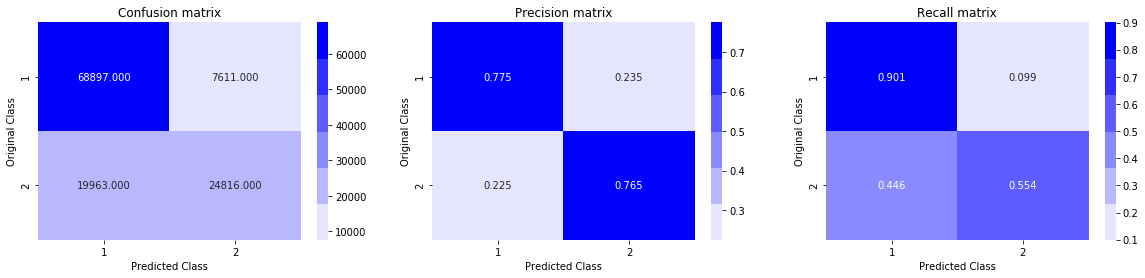

In [26]:
C = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in C:
    clf = LogisticRegression(C=i, random_state=42)
    clf.fit(tfidf_train, Y_tr)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(tfidf_train, Y_tr)
    predict_y = sig_clf.predict_proba(tfidf_val)
    log_error_array.append(log_loss(Y_CV, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The validation log loss is:",log_loss(Y_CV, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(C, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((C[i],np.round(txt,3)), (C[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each C")
plt.xlabel("C's")
plt.ylabel("Error measure")
plt.show()


best_C = np.argmin(log_error_array)
print("The best C for the Logistic Regression model is : {}".format(C[best_C]))
clf = LogisticRegression(C=C[best_C], random_state=42)
clf.fit(tfidf_train, Y_tr)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(tfidf_train, Y_tr)

predict_y = sig_clf.predict_proba(tfidf_train)
print('For values of best C = ', C[best_C], "The train log loss is:",log_loss(Y_tr, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(tfidf_test)
print('For values of best C = ', C[best_C], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_test, predicted_y)

#### SKLEARN LINEAR_MODEL'S SGDCLASSIFIER

For values of alpha =  1e-05 The validation log loss is: 0.3937319240671276
For values of alpha =  0.0001 The validation log loss is: 0.4045784321033562
For values of alpha =  0.001 The validation log loss is: 0.42527186577959514
For values of alpha =  0.01 The validation log loss is: 0.4505981015304191
For values of alpha =  0.1 The validation log loss is: 0.4584851244954659
For values of alpha =  1 The validation log loss is: 0.4934936384380092
For values of alpha =  10 The validation log loss is: 0.5440310872608639


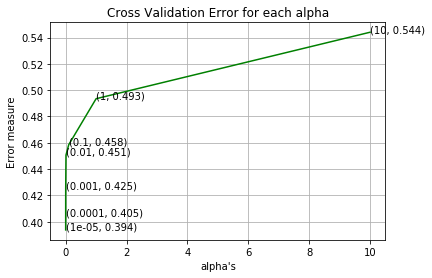

The best alpha for the SGDClassifier with log loss is : 1e-05
For values of best alpha =  1e-05 The train log loss is: 0.38933340897393476
For values of best alpha =  1e-05 The test log loss is: 0.394994615383781
Total number of data points : 121287


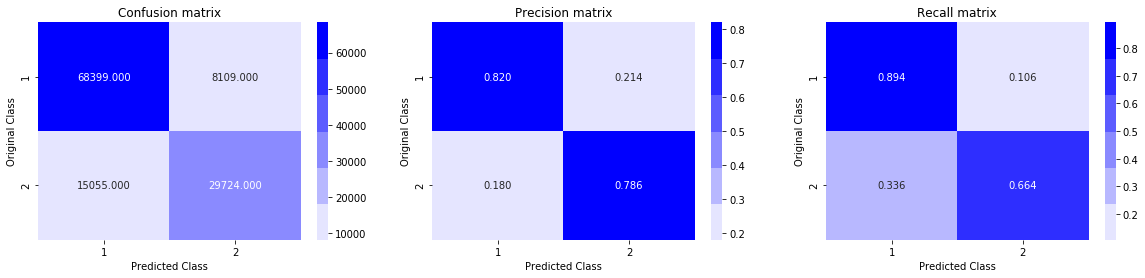

In [28]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty = 'L2', loss = 'log', random_state=42)
    clf.fit(tfidf_train, Y_tr)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(tfidf_train, Y_tr)
    predict_y = sig_clf.predict_proba(tfidf_val)
    log_error_array.append(log_loss(Y_CV, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The validation log loss is:",log_loss(Y_CV, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("alpha's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
print("The best alpha for the SGDClassifier with log loss is : {}".format(alpha[best_alpha]))
clf = SGDClassifier(alpha=alpha[best_alpha], penalty = 'L2', loss = 'log', random_state=42)
clf.fit(tfidf_train, Y_tr)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(tfidf_train, Y_tr)

predict_y = sig_clf.predict_proba(tfidf_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_tr, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(tfidf_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_test, predicted_y)

## LINEAR SVM

#### SKLEARN LINEAR MODEL SGDCLASSIFIER

For values of alpha =  1e-05 The validation log loss is: 0.38266938536047573
For values of alpha =  0.0001 The validation log loss is: 0.3992953210902881
For values of alpha =  0.001 The validation log loss is: 0.41630580260666417
For values of alpha =  0.01 The validation log loss is: 0.44581120099525584
For values of alpha =  0.1 The validation log loss is: 0.46012528009050946
For values of alpha =  1 The validation log loss is: 0.4828513419761687
For values of alpha =  10 The validation log loss is: 0.5435139360831228


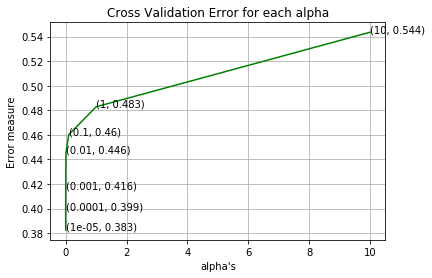

The best alpha for the SGDClassifier with hinge loss is : 1e-05
For values of best alpha =  1e-05 The train log loss is: 0.37745507134333484
For values of best alpha =  1e-05 The test log loss is: 0.3837582893898487
Total number of data points : 121287


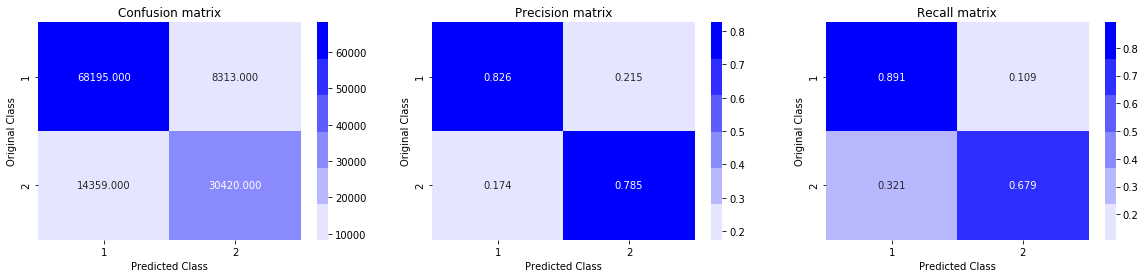

In [26]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty = 'L2', loss = 'hinge', random_state=42)
    clf.fit(tfidf_train, Y_tr)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(tfidf_train, Y_tr)
    predict_y = sig_clf.predict_proba(tfidf_val)
    log_error_array.append(log_loss(Y_CV, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The validation log loss is:",log_loss(Y_CV, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("alpha's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
print("The best alpha for the SGDClassifier with hinge loss is : {}".format(alpha[best_alpha]))
clf = SGDClassifier(alpha=alpha[best_alpha], penalty = 'L2', loss = 'hinge', random_state=42)
clf.fit(tfidf_train, Y_tr)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(tfidf_train, Y_tr)

predict_y = sig_clf.predict_proba(tfidf_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_tr, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(tfidf_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_test, predicted_y)

## XGBOOST

#### IMPORTING THE FINAL FEATURES

In [26]:
if os.path.isfile("final_features.csv"):
    fin_features_train = pd.read_csv("final_features.csv", nrows=100001)
else:
    print("download final_features_train.csv from drive or run previous notebook")

#### DISTRIBUTION OF TARGET CLASS

In [27]:
tar_dist = fin_features_train.is_duplicate.value_counts().reset_index()

tar_dist.columns = ["is_duplicate","no._of_question_pairs"]

tar_dist

,is_duplicate,no._of_question_pairs
0,0,62747
1,1,37254


In [30]:
tar_dist["percentage"] = tar_dist["no._of_question_pairs"]/np.sum(tar_dist["no._of_question_pairs"], axis=0)

tar_dist

,is_duplicate,no._of_question_pairs,percentage
0,0,62747,0.627464
1,1,37254,0.372536


### TRAIN-TEST SPLIT (70:30)

In [43]:
X = fin_features_train.drop(["Unnamed: 0","id","is_duplicate"], axis=1)
Y = fin_features_train.loc[:,"is_duplicate"]

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30, stratify = Y, random_state = 42)

### HYPERPARAMETER TUNING

The best set of parameters for the GBDT Classifier on the BOW featurized data are : {'n_estimators': 100, 'learning_rate': 0.2}


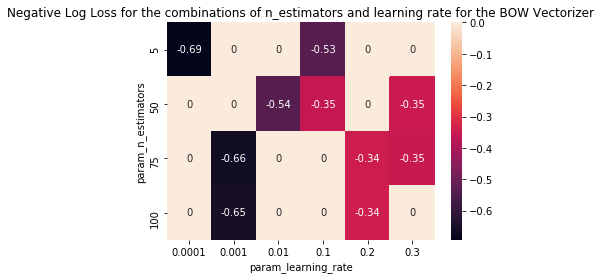

In [46]:
gb_clf = xgb.XGBClassifier()

params = {'n_estimators':[5,10,50,75,100], 'learning_rate':[0.0001,0.001,0.01,0.1,0.2,0.3]}

clf = RandomizedSearchCV(gb_clf, param_distributions = params, scoring = 'neg_log_loss', cv=3, return_train_score = True, random_state = 42)
clf.fit(X_train, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.sort_values(by = ["param_n_estimators","param_learning_rate"], inplace=True)


train_log_loss = results["mean_train_score"]
train_std = results["std_train_score"]
cv_log_loss = results["mean_test_score"]
cv_std = results["std_test_score"]

score_df = pd.pivot_table(data = results, index = "param_n_estimators", columns = "param_learning_rate", values = "mean_test_score")

# Removing the nan values from the dataset to avoid any errors during plotting of the auc scores for various combinations
score_df.fillna(0, inplace=True)

sns.heatmap(score_df, annot = True)
plt.title("Negative Log Loss for the combinations of n_estimators and learning rate for the BOW Vectorizer")

print("The best set of parameters for the GBDT Classifier on the BOW featurized data are : {}".format(clf.best_params_))

### BEST XGBOOST MODEL RESULTS

The training log loss for the best XGBoost Model is : 0.21578534685718756
The test log loss for the best XGBoost Model is : 0.3413255866304889
Total number of data points : 30001


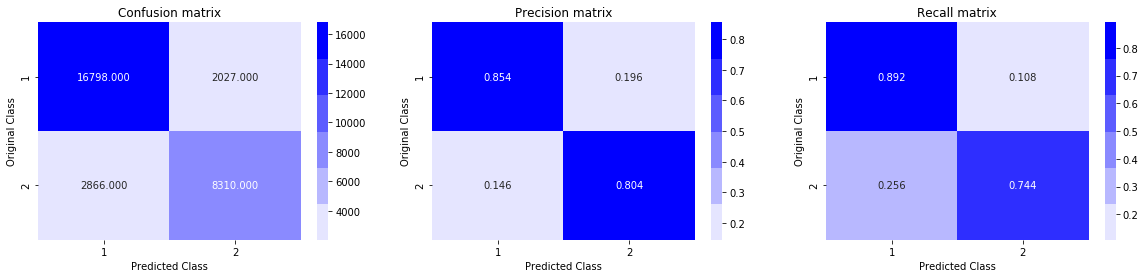

In [47]:
best_n_estimators = 100
best_learning_rate = 0.2

xgb_clf = xgb.XGBClassifier(n_estimators = best_n_estimators, learning_rate = best_learning_rate)
xgb_clf.fit(X_train, Y_train)

sig_clf = CalibratedClassifierCV(xgb_clf, method="sigmoid")
sig_clf.fit(X_train, Y_train)

predicted_y = sig_clf.predict_proba(X_train)
print("The training log loss for the best XGBoost Model is : {}".format(log_loss(Y_train, predicted_y, labels=xgb_clf.classes_, eps=1e-15)))
predicted_y = sig_clf.predict_proba(X_test)
print("The test log loss for the best XGBoost Model is : {}".format(log_loss(Y_test, predicted_y, labels=xgb_clf.classes_, eps=1e-15)))

prediction =np.argmax(predicted_y,axis=1)
print("Total number of data points :", len(prediction))
plot_confusion_matrix(Y_test, prediction)